Loading embedding data...
Manual embeddings shape: (41, 128)
Manual SMILES count: 41
GAN embeddings shape: torch.Size([9, 128])
GAN SMILES count: 41
Trimming GAN SMILES list to match embeddings length
Number of common molecules: 9
Selected query SMILES: COc1cccc(c2cccc(F)c2C(=O)[O-])c1
Manual query index: 7
GAN query index: 7
Finding similar molecules in manual embedding space...
Finding similar molecules in GAN embedding space...
Calculating fingerprint similarities for manual molecules...
Calculating fingerprint similarities for GAN molecules...
Creating comparison visualizations...


[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerator
[17:17:40] DEPRECATION WARNING: please use MorganGenerat

Saved rdkfp_comparison.png
Saved ecfp_comparison.png
Saved comprehensive_comparison.png
Visualizations saved successfully!

Top manual embedding similar molecules:
1. Emb: 1.000, ECFP: 0.151, RDKFP: 0.303
2. Emb: 1.000, ECFP: 0.096, RDKFP: 0.291
3. Emb: 1.000, ECFP: 0.094, RDKFP: 0.255
4. Emb: 0.999, ECFP: 0.094, RDKFP: 0.246
5. Emb: 0.999, ECFP: 0.144, RDKFP: 0.275
6. Emb: 0.999, ECFP: 0.087, RDKFP: 0.183
7. Emb: 0.999, ECFP: 0.089, RDKFP: 0.229
8. Emb: 0.999, ECFP: 0.085, RDKFP: 0.244

Top GAN embedding similar molecules:
1. Emb: 0.965, ECFP: 0.066, RDKFP: 0.239
2. Emb: 0.733, ECFP: 0.092, RDKFP: 0.212
3. Emb: 0.715, ECFP: 0.071, RDKFP: 0.212
4. Emb: 0.683, ECFP: 0.105, RDKFP: 0.203
5. Emb: 0.244, ECFP: 0.094, RDKFP: 0.246
6. Emb: 0.229, ECFP: 0.144, RDKFP: 0.275
7. Emb: 0.213, ECFP: 0.089, RDKFP: 0.229
8. Emb: 0.025, ECFP: 0.074, RDKFP: 0.147


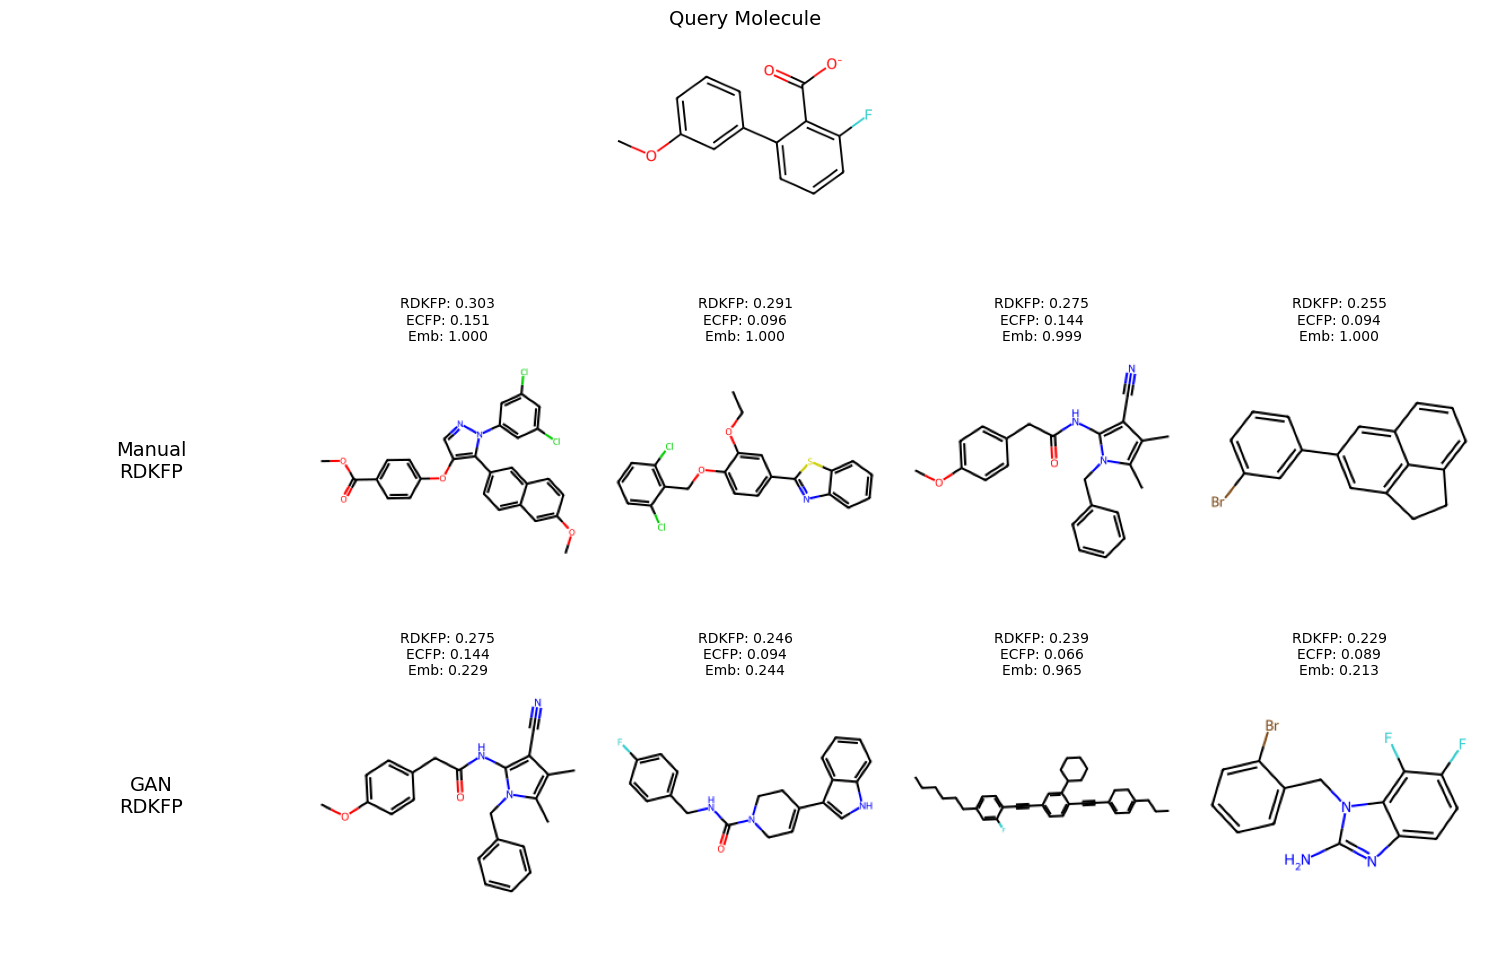

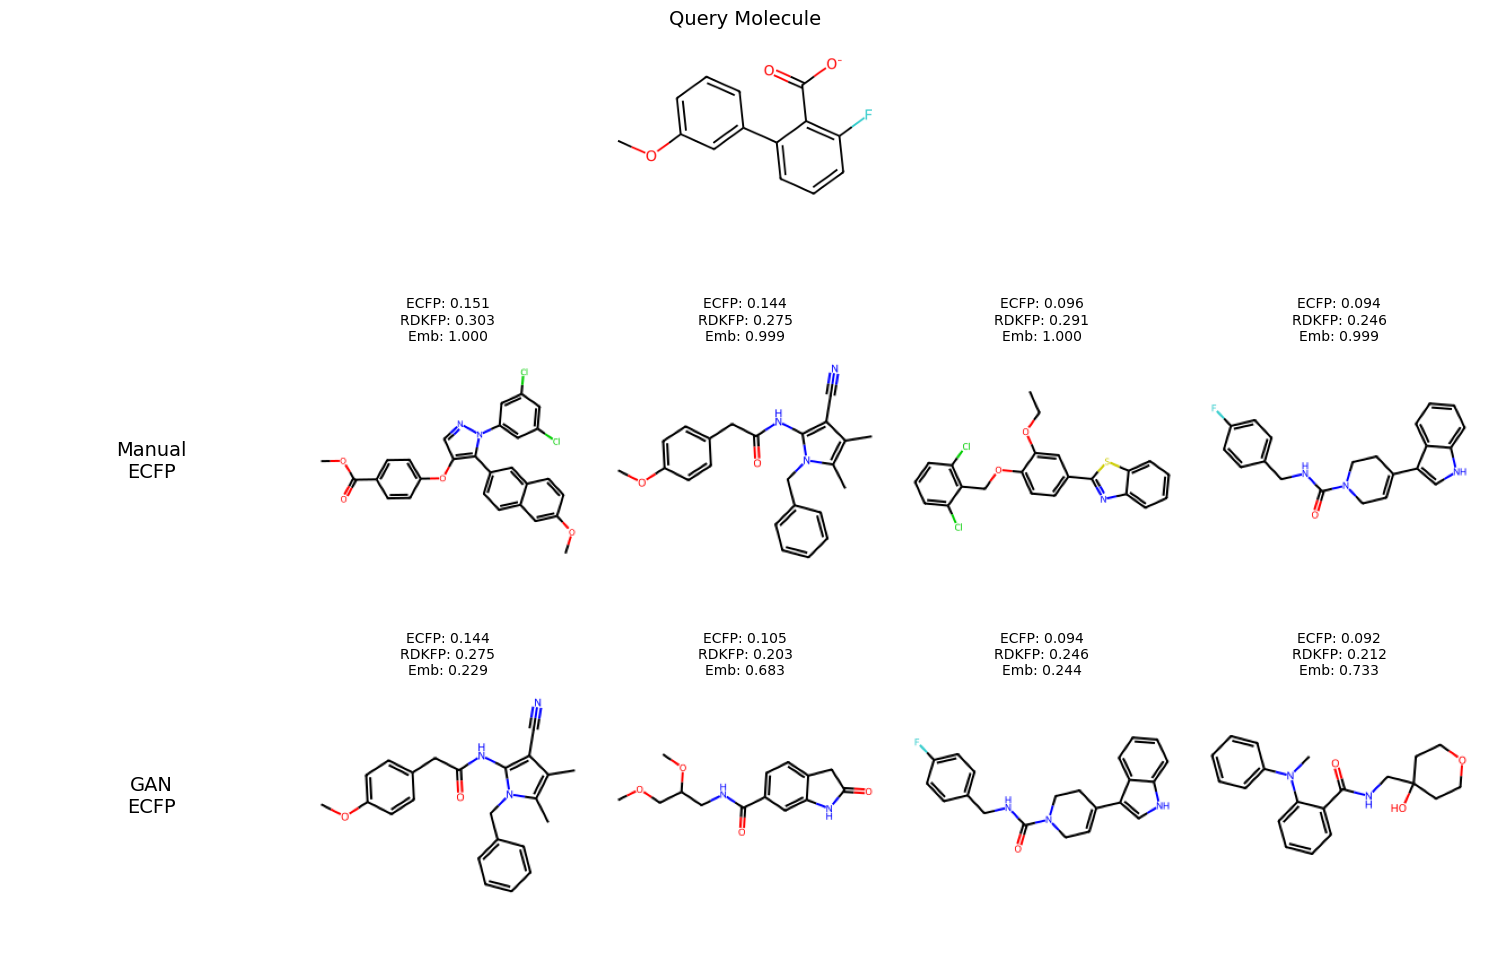

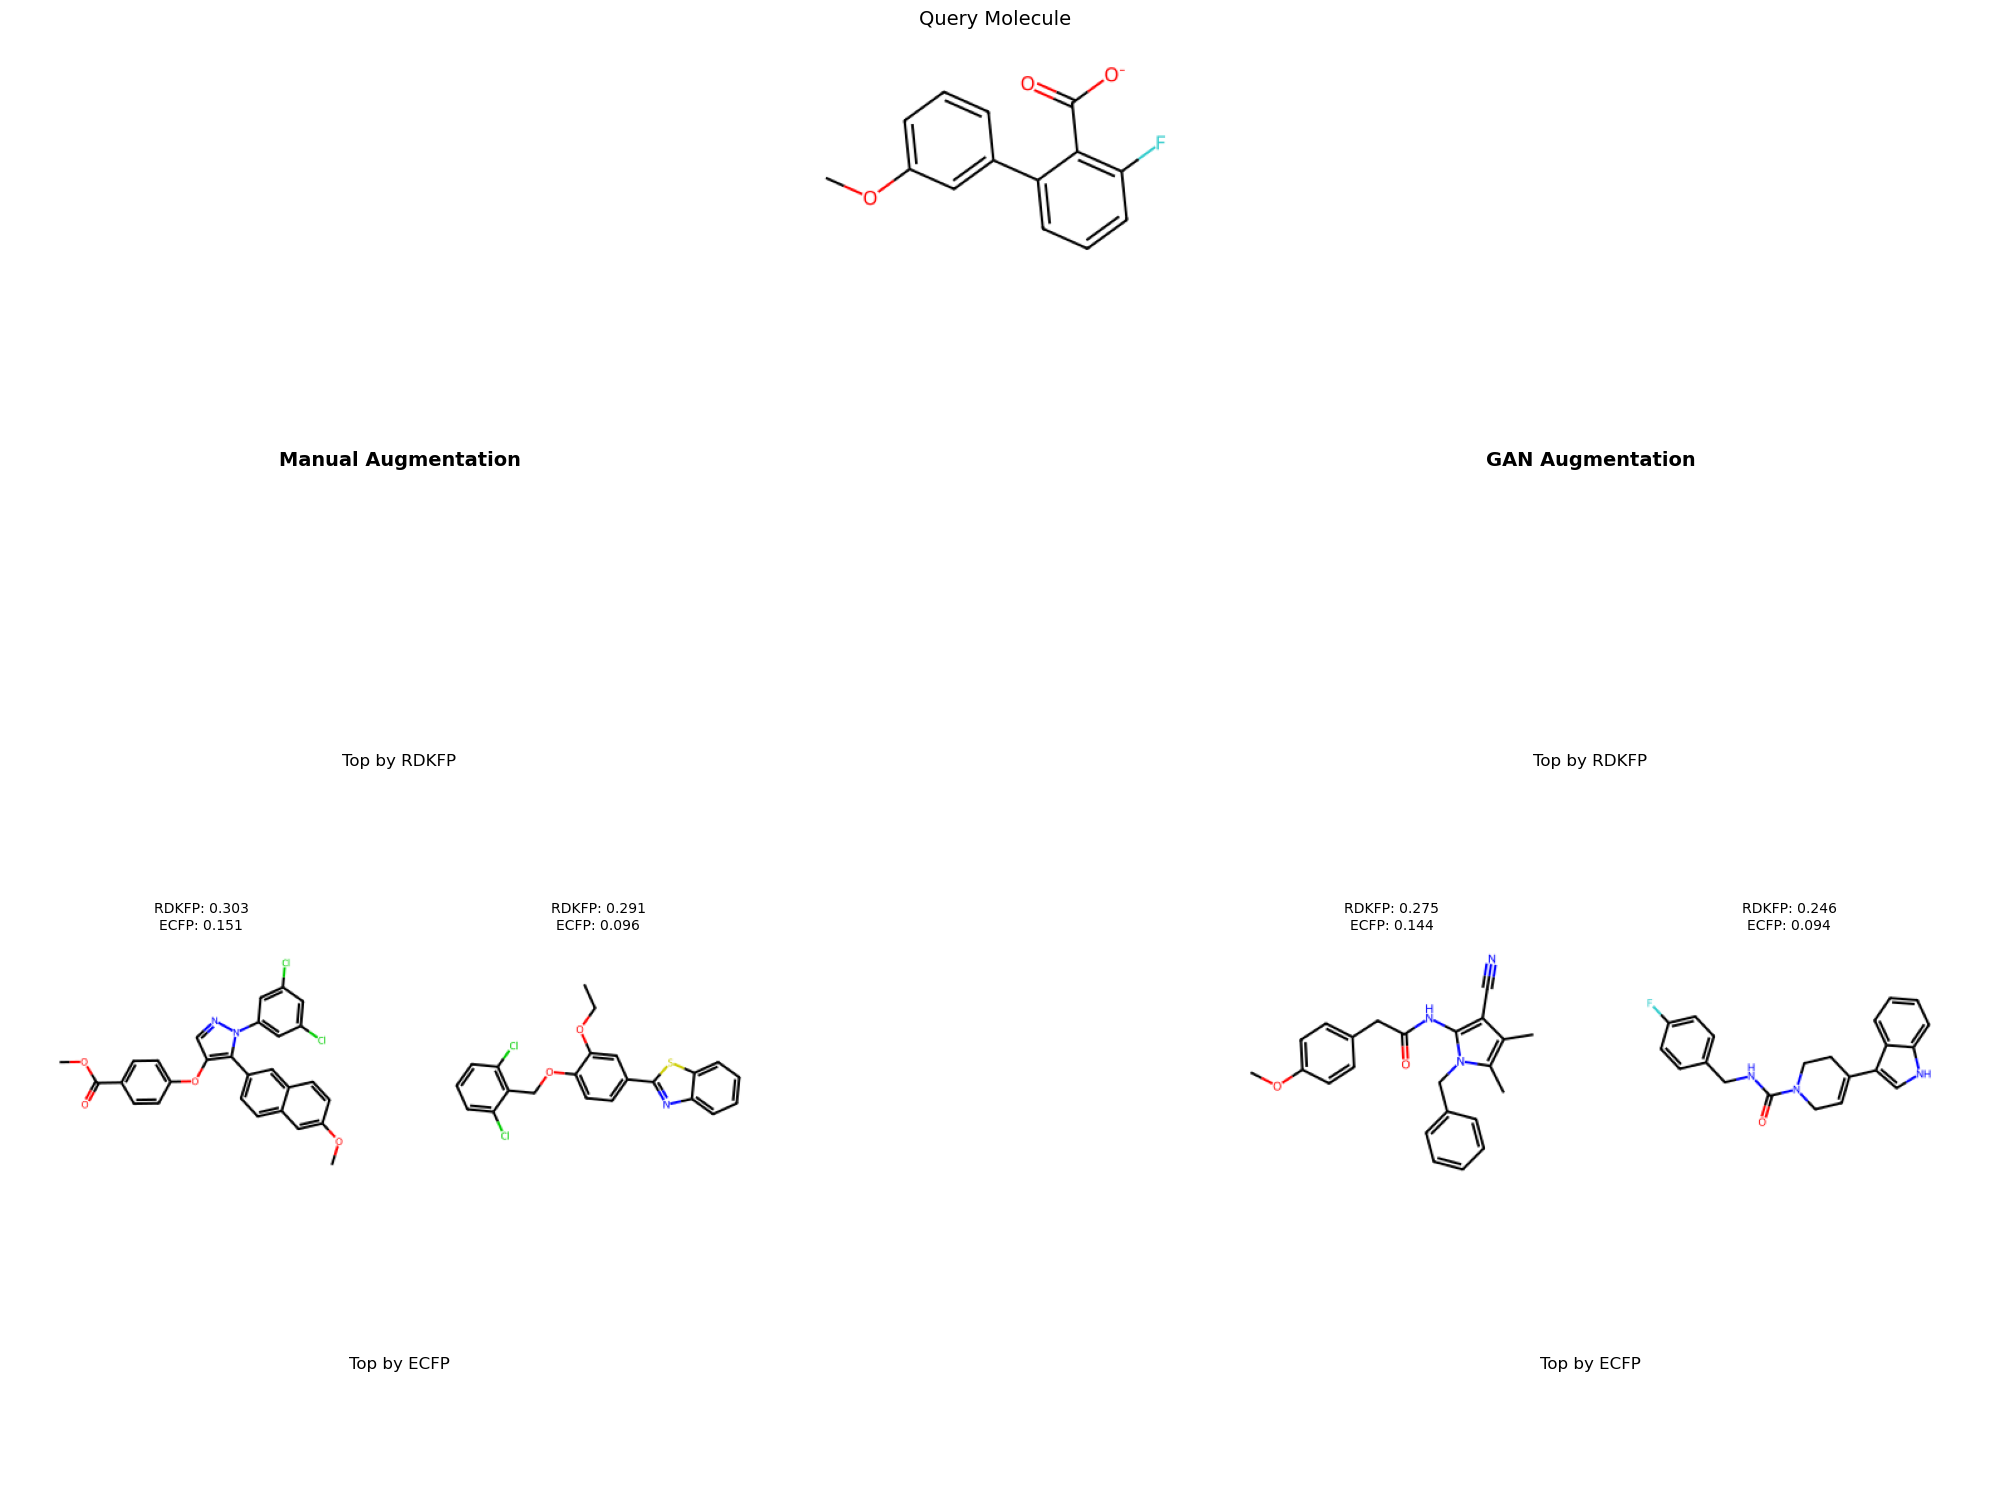

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem import DataStructs
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import random

# Function to load embeddings
def load_embeddings(filepath):
    try:
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        return data
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        # Return dummy data for testing
        return {
            'embeddings': np.random.rand(50, 128),
            'smiles_list': [f"CC{i}" for i in range(50)],
            'molecule_data': [{'smiles': f"CC{i}"} for i in range(50)]
        }

def find_similar_molecules_from_embeddings(embeddings, smiles_list, query_idx, n=8):
    """Find molecules similar to the query in embedding space"""
    # Get query embedding
    query_embedding = embeddings[query_idx].reshape(1, -1)
    
    # Calculate cosine similarities
    similarities = cosine_similarity(query_embedding, embeddings).flatten()
    
    # Get top indices (excluding the query itself)
    top_indices = np.argsort(-similarities)
    top_indices = [idx for idx in top_indices if idx != query_idx][:n]
    
    # Return SMILES strings and similarities
    return [(smiles_list[idx], similarities[idx]) for idx in top_indices]

# Function to calculate fingerprint similarities
def calculate_fingerprint_similarities(query_smiles, similar_smiles_list):
    results = []
    
    # Parse query molecule
    query_mol = Chem.MolFromSmiles(query_smiles)
    if query_mol is None:
        print(f"Error: Could not parse query SMILES: {query_smiles}")
        return []
    
    # Calculate ECFP and RDKFP for query molecule
    query_ecfp = AllChem.GetMorganFingerprintAsBitVect(query_mol, 3, nBits=2048)
    query_rdkfp = Chem.RDKFingerprint(query_mol, fpSize=2048)
    
    for smiles, emb_sim in similar_smiles_list:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                print(f"Warning: Could not parse SMILES: {smiles}")
                continue
                
            # Calculate fingerprints
            mol_ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
            mol_rdkfp = Chem.RDKFingerprint(mol, fpSize=2048)
            
            # Calculate similarities
            ecfp_sim = DataStructs.TanimotoSimilarity(query_ecfp, mol_ecfp)
            rdkfp_sim = DataStructs.TanimotoSimilarity(query_rdkfp, mol_rdkfp)
            
            results.append((smiles, emb_sim, ecfp_sim, rdkfp_sim))
        except Exception as e:
            print(f"Error processing molecule {smiles}: {e}")
    
    return results

# Function to create visualization
def create_comparison_visualization(query_smiles, manual_similar, gan_similar):
    # Convert molecules to RDKit mol objects
    query_mol = Chem.MolFromSmiles(query_smiles)
    
    # Sort by RDKFP similarity
    manual_by_rdkfp = sorted(manual_similar, key=lambda x: x[3], reverse=True)
    gan_by_rdkfp = sorted(gan_similar, key=lambda x: x[3], reverse=True)
    
    # Sort by ECFP similarity
    manual_by_ecfp = sorted(manual_similar, key=lambda x: x[2], reverse=True)
    gan_by_ecfp = sorted(gan_similar, key=lambda x: x[2], reverse=True)
    
    # Create figure for visualization
    fig = plt.figure(figsize=(15, 10))
    
    # Query molecule at the top
    ax_query = plt.subplot2grid((3, 5), (0, 2))
    query_img = Draw.MolToImage(query_mol, size=(300, 200))
    ax_query.imshow(query_img)
    ax_query.set_title('Query Molecule', fontsize=14)
    ax_query.axis('off')
    
    # Manual RDKFP row
    ax_manual_title = plt.subplot2grid((3, 5), (1, 0))
    ax_manual_title.text(0.5, 0.5, 'Manual\nRDKFP', ha='center', va='center', fontsize=14)
    ax_manual_title.axis('off')
    
    # Add manual top RDKFP molecules
    for i, (smiles, emb_sim, ecfp_sim, rdkfp_sim) in enumerate(manual_by_rdkfp[:4], start=1):
        ax = plt.subplot2grid((3, 5), (1, i))
        mol = Chem.MolFromSmiles(smiles)
        img = Draw.MolToImage(mol, size=(250, 200))
        ax.imshow(img)
        ax.set_title(f"RDKFP: {rdkfp_sim:.3f}\nECFP: {ecfp_sim:.3f}\nEmb: {emb_sim:.3f}", fontsize=10)
        ax.axis('off')
    
    # GAN RDKFP row
    ax_gan_title = plt.subplot2grid((3, 5), (2, 0))
    ax_gan_title.text(0.5, 0.5, 'GAN\nRDKFP', ha='center', va='center', fontsize=14)
    ax_gan_title.axis('off')
    
    # Add GAN top RDKFP molecules
    for i, (smiles, emb_sim, ecfp_sim, rdkfp_sim) in enumerate(gan_by_rdkfp[:4], start=1):
        ax = plt.subplot2grid((3, 5), (2, i))
        mol = Chem.MolFromSmiles(smiles)
        img = Draw.MolToImage(mol, size=(250, 200))
        ax.imshow(img)
        ax.set_title(f"RDKFP: {rdkfp_sim:.3f}\nECFP: {ecfp_sim:.3f}\nEmb: {emb_sim:.3f}", fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('rdkfp_comparison.png', dpi=300, bbox_inches='tight')
    print("Saved rdkfp_comparison.png")
    
    # Create another figure for ECFP comparison
    fig = plt.figure(figsize=(15, 10))
    
    # Query molecule at the top
    ax_query = plt.subplot2grid((3, 5), (0, 2))
    ax_query.imshow(query_img)
    ax_query.set_title('Query Molecule', fontsize=14)
    ax_query.axis('off')
    
    # Manual ECFP row
    ax_manual_title = plt.subplot2grid((3, 5), (1, 0))
    ax_manual_title.text(0.5, 0.5, 'Manual\nECFP', ha='center', va='center', fontsize=14)
    ax_manual_title.axis('off')
    
    # Add manual top ECFP molecules
    for i, (smiles, emb_sim, ecfp_sim, rdkfp_sim) in enumerate(manual_by_ecfp[:4], start=1):
        ax = plt.subplot2grid((3, 5), (1, i))
        mol = Chem.MolFromSmiles(smiles)
        img = Draw.MolToImage(mol, size=(250, 200))
        ax.imshow(img)
        ax.set_title(f"ECFP: {ecfp_sim:.3f}\nRDKFP: {rdkfp_sim:.3f}\nEmb: {emb_sim:.3f}", fontsize=10)
        ax.axis('off')
    
    # GAN ECFP row
    ax_gan_title = plt.subplot2grid((3, 5), (2, 0))
    ax_gan_title.text(0.5, 0.5, 'GAN\nECFP', ha='center', va='center', fontsize=14)
    ax_gan_title.axis('off')
    
    # Add GAN top ECFP molecules
    for i, (smiles, emb_sim, ecfp_sim, rdkfp_sim) in enumerate(gan_by_ecfp[:4], start=1):
        ax = plt.subplot2grid((3, 5), (2, i))
        mol = Chem.MolFromSmiles(smiles)
        img = Draw.MolToImage(mol, size=(250, 200))
        ax.imshow(img)
        ax.set_title(f"ECFP: {ecfp_sim:.3f}\nRDKFP: {rdkfp_sim:.3f}\nEmb: {emb_sim:.3f}", fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('ecfp_comparison.png', dpi=300, bbox_inches='tight')
    print("Saved ecfp_comparison.png")
    
    # Create a comprehensive comparison
    fig = plt.figure(figsize=(20, 15))
    
    # Query molecule in the center top
    ax_query = plt.subplot2grid((5, 5), (0, 2))
    ax_query.imshow(query_img)
    ax_query.set_title('Query Molecule', fontsize=14)
    ax_query.axis('off')
    
    # Manual embedding title (top left)
    ax_manual_title = plt.subplot2grid((5, 5), (1, 0), colspan=2)
    ax_manual_title.text(0.5, 0.5, 'Manual Augmentation', ha='center', va='center', fontsize=14, weight='bold')
    ax_manual_title.axis('off')
    
    # GAN embedding title (top right)
    ax_gan_title = plt.subplot2grid((5, 5), (1, 3), colspan=2)
    ax_gan_title.text(0.5, 0.5, 'GAN Augmentation', ha='center', va='center', fontsize=14, weight='bold')
    ax_gan_title.axis('off')
    
    # Manual RDKFP title
    ax_manual_rdkfp = plt.subplot2grid((5, 5), (2, 0), colspan=2)
    ax_manual_rdkfp.text(0.5, 0.5, 'Top by RDKFP', ha='center', va='center', fontsize=12)
    ax_manual_rdkfp.axis('off')
    
    # GAN RDKFP title
    ax_gan_rdkfp = plt.subplot2grid((5, 5), (2, 3), colspan=2)
    ax_gan_rdkfp.text(0.5, 0.5, 'Top by RDKFP', ha='center', va='center', fontsize=12)
    ax_gan_rdkfp.axis('off')
    
    # Manual RDKFP molecules
    for i, (smiles, emb_sim, ecfp_sim, rdkfp_sim) in enumerate(manual_by_rdkfp[:2]):
        ax = plt.subplot2grid((5, 5), (3, i))
        mol = Chem.MolFromSmiles(smiles)
        img = Draw.MolToImage(mol, size=(250, 200))
        ax.imshow(img)
        ax.set_title(f"RDKFP: {rdkfp_sim:.3f}\nECFP: {ecfp_sim:.3f}", fontsize=10)
        ax.axis('off')
    
    # GAN RDKFP molecules
    for i, (smiles, emb_sim, ecfp_sim, rdkfp_sim) in enumerate(gan_by_rdkfp[:2]):
        ax = plt.subplot2grid((5, 5), (3, i+3))
        mol = Chem.MolFromSmiles(smiles)
        img = Draw.MolToImage(mol, size=(250, 200))
        ax.imshow(img)
        ax.set_title(f"RDKFP: {rdkfp_sim:.3f}\nECFP: {ecfp_sim:.3f}", fontsize=10)
        ax.axis('off')
    
    # Add ECFP related content if there's enough space in the figure
    try:
        # Manual ECFP title
        ax_manual_ecfp = plt.subplot2grid((5, 5), (4, 0), colspan=2)
        ax_manual_ecfp.text(0.5, 0.5, 'Top by ECFP', ha='center', va='center', fontsize=12)
        ax_manual_ecfp.axis('off')
        
        # GAN ECFP title
        ax_gan_ecfp = plt.subplot2grid((5, 5), (4, 3), colspan=2)
        ax_gan_ecfp.text(0.5, 0.5, 'Top by ECFP', ha='center', va='center', fontsize=12)
        ax_gan_ecfp.axis('off')
    except:
        pass
    
    plt.tight_layout()
    plt.savefig('comprehensive_comparison.png', dpi=300, bbox_inches='tight')
    print("Saved comprehensive_comparison.png")
    
    print("Visualizations saved successfully!")

# Main execution
print("Loading embedding data...")
# Load embedding data for both manual and GAN
manual_data = load_embeddings('./embeddings/final_embeddings_molecules_20250310_143038.pkl')
gan_data = load_embeddings('./embeddings/final_embeddings_molecules_20250310_142842.pkl')

# Extract embeddings and SMILES lists with error handling
manual_embeddings = manual_data.get('embeddings', np.array([]))
if isinstance(manual_embeddings, list):
    manual_embeddings = np.array(manual_embeddings)

# Get manual SMILES list
if 'smiles_list' in manual_data and manual_data['smiles_list']:
    manual_smiles = manual_data['smiles_list']
elif 'molecule_data' in manual_data:
    manual_smiles = [mol.get('smiles', '') for mol in manual_data['molecule_data']]
else:
    print("Warning: Could not find SMILES in manual data, using dummy data")
    manual_smiles = [f"CC{i}" for i in range(len(manual_embeddings))]

# Get GAN embeddings and SMILES
gan_embeddings = gan_data.get('embeddings', np.array([]))
if isinstance(gan_embeddings, list):
    gan_embeddings = np.array(gan_embeddings)

if 'smiles_list' in gan_data and gan_data['smiles_list']:
    gan_smiles = gan_data['smiles_list']
elif 'molecule_data' in gan_data:
    gan_smiles = [mol.get('smiles', '') for mol in gan_data['molecule_data']]
else:
    print("Warning: Could not find SMILES in GAN data, using dummy data")
    gan_smiles = [f"CC{i}" for i in range(len(gan_embeddings))]

print(f"Manual embeddings shape: {manual_embeddings.shape if hasattr(manual_embeddings, 'shape') else 'not array'}")
print(f"Manual SMILES count: {len(manual_smiles)}")
print(f"GAN embeddings shape: {gan_embeddings.shape if hasattr(gan_embeddings, 'shape') else 'not array'}")
print(f"GAN SMILES count: {len(gan_smiles)}")

# Ensure embeddings and SMILES lists have the same length
if len(manual_smiles) > len(manual_embeddings):
    print("Trimming manual SMILES list to match embeddings length")
    manual_smiles = manual_smiles[:len(manual_embeddings)]
elif len(manual_smiles) < len(manual_embeddings):
    print("Trimming manual embeddings to match SMILES length")
    manual_embeddings = manual_embeddings[:len(manual_smiles)]

if len(gan_smiles) > len(gan_embeddings):
    print("Trimming GAN SMILES list to match embeddings length")
    gan_smiles = gan_smiles[:len(gan_embeddings)]
elif len(gan_smiles) < len(gan_embeddings):
    print("Trimming GAN embeddings to match SMILES length")
    gan_embeddings = gan_embeddings[:len(gan_smiles)]

# Find common molecules to select a query from
common_smiles = list(set(manual_smiles) & set(gan_smiles))
print(f"Number of common molecules: {len(common_smiles)}")

if not common_smiles:
    print("No common molecules found. Using separate queries for each method.")
    # Select arbitrary indices if no common molecules
    manual_query_idx = 0
    gan_query_idx = 0
    
    query_smiles_manual = manual_smiles[manual_query_idx]
    query_smiles_gan = gan_smiles[gan_query_idx]
    
    print(f"Manual query: {query_smiles_manual}")
    print(f"GAN query: {query_smiles_gan}")
    
    # This case isn't ideal as we want to compare the same query molecule
    print("WARNING: Using different query molecules doesn't allow direct comparison.")
else:
    # Select a common query molecule - safely select an index within range
    query_idx = 5 if len(common_smiles) <= 1 else random.randint(0, len(common_smiles) - 1)
    query_smiles = common_smiles[query_idx]
    print(f"Selected query SMILES: {query_smiles}")
    
    # Find its indices in each dataset
    manual_query_idx = manual_smiles.index(query_smiles)
    gan_query_idx = gan_smiles.index(query_smiles)
    
    print(f"Manual query index: {manual_query_idx}")
    print(f"GAN query index: {gan_query_idx}")
    
    # Find similar molecules in each embedding space
    print("Finding similar molecules in manual embedding space...")
    manual_similar = find_similar_molecules_from_embeddings(
        manual_embeddings, manual_smiles, manual_query_idx, n=8
    )
    
    print("Finding similar molecules in GAN embedding space...")
    gan_similar = find_similar_molecules_from_embeddings(
        gan_embeddings, gan_smiles, gan_query_idx, n=8
    )
    
    # Calculate fingerprint similarities for all similar molecules
    print("Calculating fingerprint similarities for manual molecules...")
    manual_similar_with_fps = calculate_fingerprint_similarities(query_smiles, manual_similar)
    
    print("Calculating fingerprint similarities for GAN molecules...")
    gan_similar_with_fps = calculate_fingerprint_similarities(query_smiles, gan_similar)
    
    # Create visualizations comparing the two approaches
    print("Creating comparison visualizations...")
    create_comparison_visualization(query_smiles, manual_similar_with_fps, gan_similar_with_fps)
    
    # Print a summary of findings
    print("\nTop manual embedding similar molecules:")
    for i, (smiles, emb_sim, ecfp_sim, rdkfp_sim) in enumerate(manual_similar_with_fps):
        print(f"{i+1}. Emb: {emb_sim:.3f}, ECFP: {ecfp_sim:.3f}, RDKFP: {rdkfp_sim:.3f}")
    
    print("\nTop GAN embedding similar molecules:")
    for i, (smiles, emb_sim, ecfp_sim, rdkfp_sim) in enumerate(gan_similar_with_fps):
        print(f"{i+1}. Emb: {emb_sim:.3f}, ECFP: {ecfp_sim:.3f}, RDKFP: {rdkfp_sim:.3f}")